Epoch 0 | Loss = 5031.621094 | r = 0.009000
Epoch 500 | Loss = 3277.818604 | r = 0.003542
Epoch 1000 | Loss = 2278.858154 | r = 0.006680
Epoch 1500 | Loss = 1554.582886 | r = -0.000799
Epoch 2000 | Loss = 1034.310913 | r = -0.000249
Epoch 2500 | Loss = 675.420105 | r = -0.000119
Epoch 3000 | Loss = 443.277191 | r = -0.000068
Epoch 3500 | Loss = 306.592651 | r = -0.000044
Epoch 4000 | Loss = 236.257660 | r = -0.000031
Epoch 4500 | Loss = 206.350967 | r = -0.000023

🔍 Valor estimado de r: -0.00002


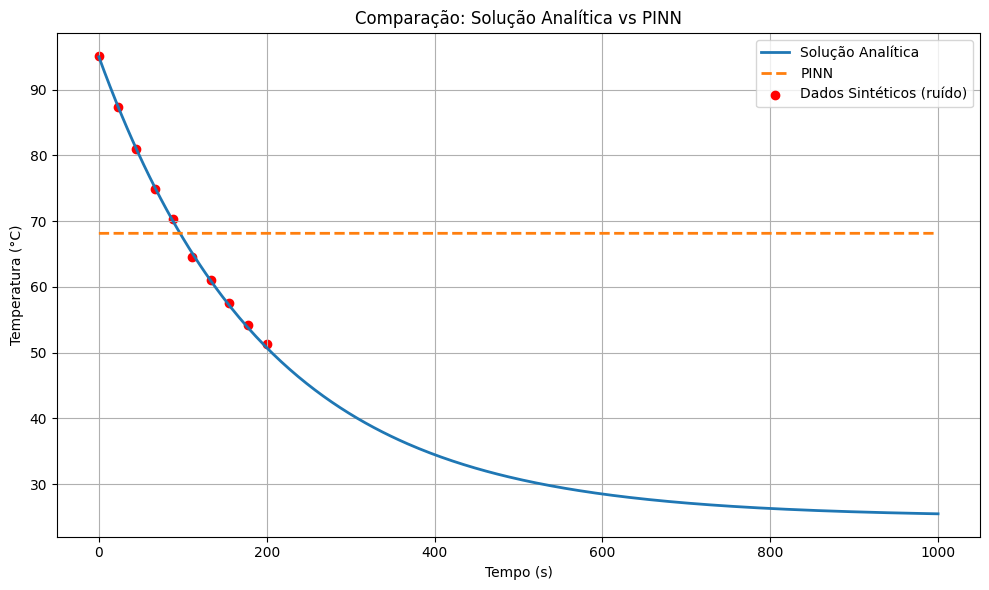

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -----------------------------
# Dados sintéticos
# -----------------------------
T_amb = 25.0
t_train = torch.linspace(0, 200, 10).view(-1, 1)
T_real = T_amb + (95 - T_amb) * torch.exp(-0.005 * t_train)
T_noise = T_real + 0.5 * torch.randn_like(T_real)  # ruído gaussiano

# -----------------------------
# Modelo PINN
# -----------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        self.r = nn.Parameter(torch.tensor(0.01))  # chute inicial para r

    def forward(self, t):
        return self.net(t)

# -----------------------------
# Função de perda
# -----------------------------
def loss_fn(model, t, T_data):
    t.requires_grad = True
    T_pred = model(t)

    dTdt = torch.autograd.grad(
        T_pred, t,
        grad_outputs=torch.ones_like(T_pred),
        retain_graph=True,
        create_graph=True
    )[0]

    # EDO: dT/dt = r * (T_amb - T)
    physics = dTdt - model.r * (T_amb - T_pred)

    data_loss = torch.mean((T_pred - T_data) ** 2)
    physics_loss = torch.mean(physics ** 2)

    return data_loss + physics_loss

# -----------------------------
# Treinamento
# -----------------------------
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_train, T_noise)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss = {loss.item():.6f} | r = {model.r.item():.6f}")

print(f"\n🔍 Valor estimado de r: {model.r.item():.5f}")

# -----------------------------
# Gráfico de comparação
# -----------------------------
t_test = torch.linspace(0, 1000, 300).view(-1, 1)
with torch.no_grad():
    T_pinn = model(t_test)
    T_analitica = T_amb + (95 - T_amb) * torch.exp(-0.005 * t_test)

plt.figure(figsize=(10, 6))
plt.plot(t_test, T_analitica, label='Solução Analítica', linewidth=2)
plt.plot(t_test, T_pinn, '--', label='PINN', linewidth=2)
plt.scatter(t_train.detach().numpy(), T_noise.detach().numpy(), label='Dados Sintéticos (ruído)', color='red')
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Comparação: Solução Analítica vs PINN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
